<a href="https://colab.research.google.com/github/Cool-buddies-of-ENEL645/OurAwesomeFinalProject/blob/main/Densenet_UnFreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.densenet.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.densenet.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


In [ ]:
model_name_it = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_it_unfreeze_50.h5"
model_name_ft = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_ft_unfreeze_50.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True

x1 = base_model(base_model.input, training = True)
x2 = tf.keras.layers.Flatten()(x1)


out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

29097984/29084464 [==============================] - 0s 0us/step
Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 7,299,652
Trainable params: 7,216,004
Non-trainable params: 83,648
_________________________________________________________________
None


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=50, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))


Epoch 1/50
81/81 [==============================] - 2956s 36s/step - loss: 0.7075 - accuracy: 0.7607 - val_loss: 0.5597 - val_accuracy: 0.8130 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 110s 1s/step - loss: 0.3412 - accuracy: 0.8733 - val_loss: 0.6352 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 110s 1s/step - loss: 0.2754 - accuracy: 0.9015 - val_loss: 0.7658 - val_accuracy: 0.7907 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 108s 1s/step - loss: 0.1951 - accuracy: 0.9253 - val_loss: 0.5966 - val_accuracy: 0.8272 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 110s 1s/step - loss: 0.1636 - accuracy: 0.9412 - val_loss: 0.5495 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 110s 1s/step - loss: 0.1293 - accuracy: 0.9514 - val_loss: 0.5145 - val_accuracy: 0.8451 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=10, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/10
81/81 [==============================] - 1596s 19s/step - loss: 0.7418 - accuracy: 0.7640 - val_loss: 0.5964 - val_accuracy: 0.8148 - lr: 1.0000e-04
Epoch 2/10
81/81 [==============================] - 98s 1s/step - loss: 0.3648 - accuracy: 0.8712 - val_loss: 0.6317 - val_accuracy: 0.7970 - lr: 1.0000e-04
Epoch 3/10
81/81 [==============================] - 98s 1s/step - loss: 0.2671 - accuracy: 0.9035 - val_loss: 0.5418 - val_accuracy: 0.8397 - lr: 1.0000e-04
Epoch 4/10
81/81 [==============================] - 97s 1s/step - loss: 0.2123 - accuracy: 0.9216 - val_loss: 0.5575 - val_accuracy: 0.8317 - lr: 1.0000e-04
Epoch 5/10
81/81 [==============================] - 98s 1s/step - loss: 0.1686 - accuracy: 0.9387 - val_loss: 0.5364 - val_accuracy: 0.8442 - lr: 1.0000e-04
Epoch 6/10
81/81 [==============================] - 97s 1s/step - loss: 0.1258 - accuracy: 0.9506 - val_loss: 0.6543 - val_accuracy: 0.8290 - lr: 1.0000e-04
Epoch 7/10
81/81 [==============================] - 96s

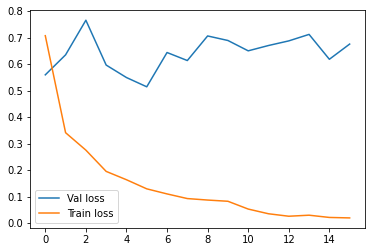

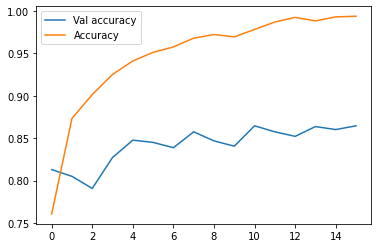

In [ ]:
it_file = open("/content/drive/My Drive/Colab Notebooks/Garbage-Classification/it_history_unfreeze.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 262148    
                                                                 
Total params: 7,299,652
Trainable params: 7,216,004
Non-trainable params: 83,648
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 110s 1s/step - loss: 0.1142 - accuracy: 0.9552 - val_loss: 0.5327 - val_accuracy: 0.8495 - lr: 1.0000e

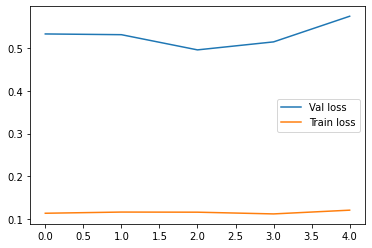

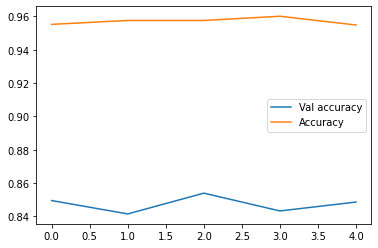

In [ ]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

ft_file = open("/content/drive/My Drive/Colab Notebooks/Garbage-Classification/ft_history_unfreeze.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = '/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Test',
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [ ]:
import os
def main():
    path = '/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Test/Take-to-recycle/'
    for count, filename in enumerate(os.listdir(path)):
        print(filename)
        [a, b] = filename.split(".")
        new_name = a + ".png"
        # print(dst)
        src = path + filename
        dst = path + new_name
        os.rename(src, dst)



# Driver Code
if __name__ == '__main__':
    # Calling main() function
    main()

battery740.jpg
battery745.jpg
battery746.jpg
battery747.jpg
battery748.jpg
battery749.jpg
battery75.jpg
battery751.jpg
battery753.jpg
battery755.jpg
battery757.jpg
battery758.jpg
battery759.jpg
battery760.jpg
battery763.jpg
battery766.jpg
battery767.jpg
battery768.jpg
battery769.jpg
battery77.jpg
battery770.jpg
battery771.jpg
battery772.jpg
battery773.jpg
battery774.jpg
battery775.jpg
battery776.jpg
battery777.jpg
battery778.jpg
battery779.jpg
battery78.jpg
battery780.jpg
battery781.jpg
battery782.jpg
battery783.jpg
battery784.jpg
battery785.jpg
battery786.jpg
battery787.jpg
battery789.jpg
battery788.jpg
battery79.jpg
battery790.jpg
battery791.jpg
battery792.jpg
battery793.jpg
battery794.jpg
battery795.jpg
battery796.jpg
battery797.jpg
battery798.jpg
battery799.jpg
battery8.jpg
battery80.jpg
battery800.jpg
battery801.jpg
battery802.jpg
battery803.jpg
battery804.jpg
battery805.jpg
battery806.jpg
battery807.jpg
battery809.jpg
battery808.jpg
battery81.jpg
battery810.jpg
battery811.jpg
bat

In [ ]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(test_generator)

# # Testing the model in the fine tuning
# model = tf.keras.models.load_model(model_name_ft)
# model.evaluate(test_generator)

13/13 [==============================] - 16s 1s/step - loss: 0.5536 - accuracy: 0.8364


[0.5535930395126343, 0.8364312052726746]

Number of wrong predictions:  15


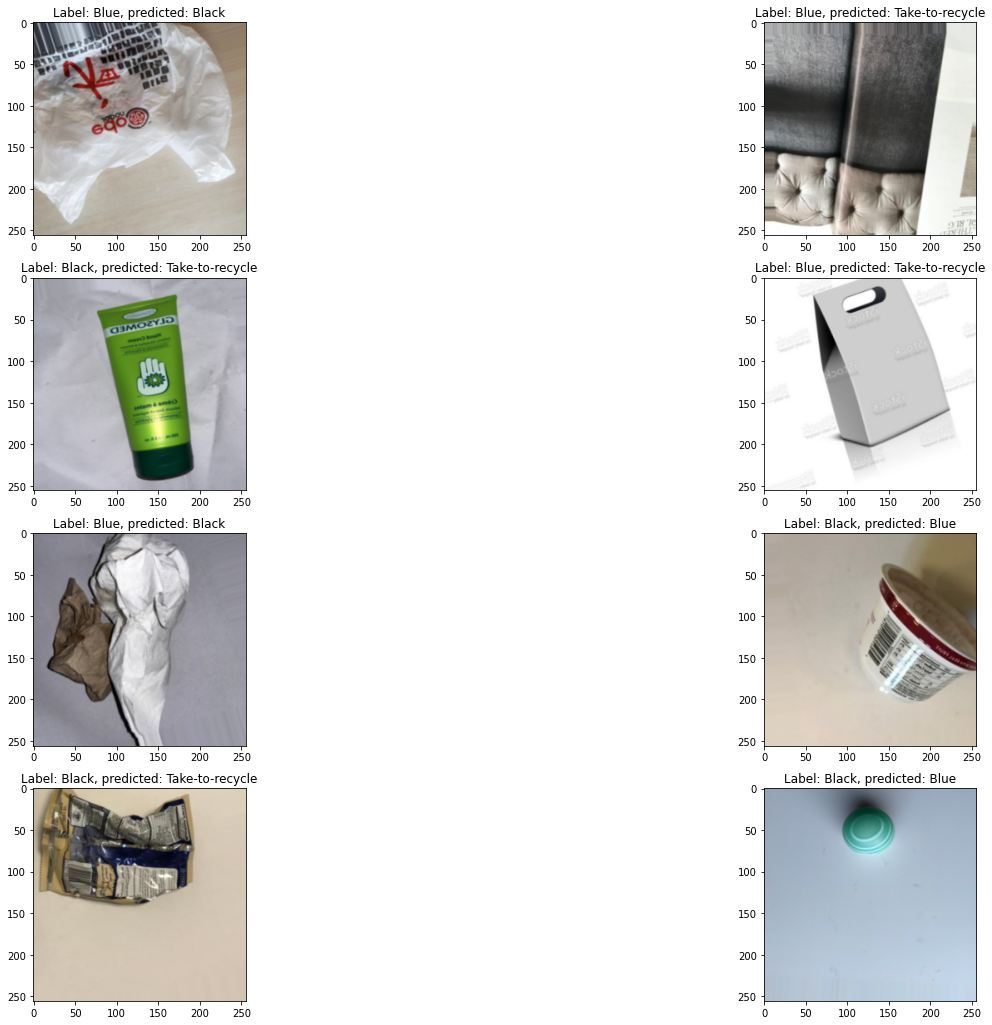

In [ ]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]
print("Number of wrong predictions: ", wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

def print_report_conf_matrix(model):
  print("--------------------------------------------------------")
  print(model.name)
  print("--------------------------------------------------------")
  Ypred = model.predict(Xtest).argmax(axis = 1)
  report = classification_report(Ytest, Ypred)
  print(report)
  plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)


--------------------------------------------------------
model
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.53      0.62        19
           1       0.69      0.69      0.69        16
           2       0.83      0.94      0.88        16
           3       0.76      1.00      0.87        13

    accuracy                           0.77        64
   macro avg       0.76      0.79      0.77        64
weighted avg       0.76      0.77      0.75        64

Confusion matrix, without normalization


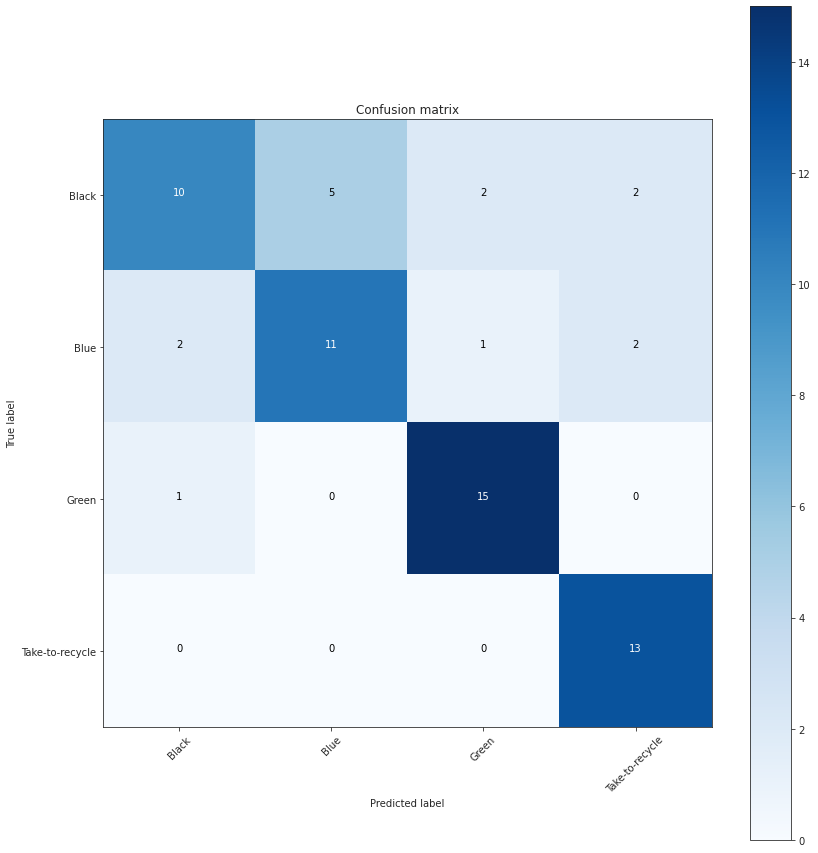

In [ ]:
print_report_conf_matrix(model)
# print_report_conf_matrix(model1)
# print_report_conf_matrix(model2)